# **Active learning comparison between the two models**

## **Preliminary steps**

In [ ]:
### PACKAGES

import copy
import torch


In [ ]:
### FUNCTIONS AND CLASSES

from src.libs import preprocessing, visualization, utils, active_learning
from src.libs.tokenizer import ReversedPairingTokenizer
from src.model.transformer import MyTransformer


In [3]:
### DEVICE

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

Using device: cpu


## **Tokenizer**

In [ ]:
### CREATE TOKENIZER

tokenizer = ReversedPairingTokenizer()
VOCAB_SIZE = tokenizer.ntokens
print(f"Vocabulary size: {VOCAB_SIZE}")


Vocabulary size: 114


## **Data**

In [ ]:
### CONSTANTS

NUM_DIGITS = 3

TRAIN_SIZE = 500
VALID_SIZE = 100
TEST_SIZE = 1000
POOL_SIZE = 1000


In [7]:
### CREATE DATASETS

train_dataset = preprocessing.create_dataset(
    nb_samples=TRAIN_SIZE, num_digits=NUM_DIGITS
)

valid_dataset = preprocessing.create_dataset(
    nb_samples=VALID_SIZE, num_digits=NUM_DIGITS
)

test_dataset = preprocessing.create_dataset(nb_samples=TEST_SIZE, num_digits=NUM_DIGITS)

pool_dataset = preprocessing.create_dataset(nb_samples=POOL_SIZE, num_digits=NUM_DIGITS)

## **MODELS**

In [8]:
### ARCHITECTURE

NB_LAYERS = 2
NB_HEADS = 8
EMBEDDING_DIMENSION = 64
HEAD_SIZE = 8  # EMBEDDING_DIMENSION // NB_HEADS
CONTEXT_LENGTH = 20
HIDDEN_DIMENSION = 8
DROPOUT_TRANSFORMER = 0.1
DROPOUT_BAYESFORMER = 0.3


In [9]:
### TRANSFORMER

transformer = MyTransformer(
    ntoken=VOCAB_SIZE,
    d_model=EMBEDDING_DIMENSION,
    n_heads=NB_HEADS,
    dim_feedforward=HIDDEN_DIMENSION,
    nlayers=NB_LAYERS,
    dropout=DROPOUT_TRANSFORMER,
).to(DEVICE)

print(
    "number of parameters: {}".format(
        sum([x.numel() for x in transformer.parameters()])
    )
)


number of parameters: 50178


In [10]:
### BAYESFORMER

bayesformer = MyTransformer(
    ntoken=VOCAB_SIZE,
    d_model=EMBEDDING_DIMENSION,
    n_heads=NB_HEADS,
    dim_feedforward=HIDDEN_DIMENSION,
    nlayers=NB_LAYERS,
    bayes_dropout=DROPOUT_BAYESFORMER,
    bayes=True,
).to(DEVICE)

print(
    "number of parameters: {}".format(
        sum([x.numel() for x in bayesformer.parameters()])
    )
)


number of parameters: 50178


## **TRAINING**

In [ ]:
### CONSTANTS

NB_EPOCHS = 5
BATCH_SIZE = 20
LEARNING_RATE = 1e-3

assert (
    TRAIN_SIZE % BATCH_SIZE == 0
    and VALID_SIZE % BATCH_SIZE == 0
    and TEST_SIZE % BATCH_SIZE == 0
), "BATCH_SIZE must be a divisor of TRAIN_SIZE, VALID_SIZE and TEST_SIZE"


In [ ]:
### TRAIN TRANSFORMER

train_losses_transformer, valid_losses_transformer = utils.train(
    model=transformer,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    nb_epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    vocab_size=VOCAB_SIZE,
    tokenizer=tokenizer,
    device=DEVICE,
)


EPOCH [1 / 5] ----------- TRAIN LOSS : 0.1870, VALID LOSS : 0.133981
EPOCH [2 / 5] ----------- TRAIN LOSS : 0.1182, VALID LOSS : 0.102733
EPOCH [3 / 5] ----------- TRAIN LOSS : 0.0994, VALID LOSS : 0.092281
EPOCH [4 / 5] ----------- TRAIN LOSS : 0.0882, VALID LOSS : 0.080030
EPOCH [5 / 5] ----------- TRAIN LOSS : 0.0792, VALID LOSS : 0.075031
Best valid loss : 0.0750


In [ ]:
### TRAIN BAYESFORMER

train_losses_bayesformer, valid_losses_bayesformer = utils.train(
    model=bayesformer,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    nb_epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    vocab_size=VOCAB_SIZE,
    tokenizer=tokenizer,
    device=DEVICE,
)


EPOCH [1 / 5] ----------- TRAIN LOSS : 0.2007, VALID LOSS : 0.153270
EPOCH [2 / 5] ----------- TRAIN LOSS : 0.1379, VALID LOSS : 0.119587
EPOCH [3 / 5] ----------- TRAIN LOSS : 0.1158, VALID LOSS : 0.108591
EPOCH [4 / 5] ----------- TRAIN LOSS : 0.1066, VALID LOSS : 0.098511
EPOCH [5 / 5] ----------- TRAIN LOSS : 0.0985, VALID LOSS : 0.094612
Best valid loss : 0.0946


## **Evaluation**

In [ ]:
### EVALUATE TRANSFORMER

accuracy_test_transformer = utils.evaluate(
    model=transformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
print(f"Transformer accuracy on test set: {accuracy_test_transformer:.2f}")

### EXAMPLES

transformer.eval()

for i in range(5):
    prompt, answers = test_dataset[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1, 1))
    output = utils.generate(transformer, prompt_tensor, len(answers) + 1, DEVICE).view(
        (1, -1)
    )
    print(tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers)


Transformer accuracy on test set: 0.01
731+810=111<EOS><PAD>	 actual result: 1541
303+666=867<EOS>	 actual result: 969
407+482=629<EOS>	 actual result: 889
875+53=686<EOS>	 actual result: 928
469+271=1243	 actual result: 740


In [ ]:
### EVALUATE BAYESFORMER

accuracy_test_bayesformer = utils.evaluate(
    model=bayesformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
print(f"Bayesformer accuracy on test set: {accuracy_test_bayesformer:.2f}")

### EXAMPLES

bayesformer.eval()

for i in range(5):
    prompt, answers = test_dataset[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1, 1))
    output = utils.generate(bayesformer, prompt_tensor, len(answers) + 1, DEVICE).view(
        (1, -1)
    )
    print(tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers)


Bayesformer accuracy on test set: 0.00
731+810=125<EOS><PAD>	 actual result: 1541
303+666=451<EOS>	 actual result: 969
407+482=15<EOS><PAD>	 actual result: 889
875+53=166<EOS>	 actual result: 928
469+271=43<EOS><PAD>	 actual result: 740


## **Active learning**

In [16]:
### CONSTANTS

AL_NB_EPOCHS = 2
AL_BATCH_SIZE = 20
AL_LEARNING_RATE = 1e-3


### Active learning with max uncertainty

In [17]:
max_greedy_transformer = copy.deepcopy(transformer)
max_sampling_transformer = copy.deepcopy(transformer)
max_dropout_bayesformer = copy.deepcopy(bayesformer)


In [18]:
### ACTIVE LEARNING WITH MAX UNCERTAINTY : GREEDY TRANSFORMER

ids_max_greedy_transformer = active_learning.select_samples(
    model=max_greedy_transformer,
    tokenizer=tokenizer,
    pool_dataset=pool_dataset,
    device=DEVICE,
    nb_samples=200,
    compute="greedy",
    mode="max",
)
max_greedy_train_dataset = active_learning.create_new_train_set(
    train_dataset=train_dataset,
    pool_dataset=pool_dataset,
    indices=ids_max_greedy_transformer,
)

max_greedy_train_losses_transformer, max_greedy_valid_losses_transformer = utils.train(
    model=max_greedy_transformer,
    train_dataset=max_greedy_train_dataset,
    valid_dataset=valid_dataset,
    nb_epochs=AL_NB_EPOCHS,
    batch_size=AL_BATCH_SIZE,
    lr=AL_LEARNING_RATE,
    vocab_size=VOCAB_SIZE,
    tokenizer=tokenizer,
    device=DEVICE,
)


EPOCH [1 / 2] ----------- TRAIN LOSS : 0.0749, VALID LOSS : 0.071351
EPOCH [2 / 2] ----------- TRAIN LOSS : 0.0694, VALID LOSS : 0.067993
Best valid loss : 0.0680


In [19]:
### ACTIVE LEARNING WITH MAX UNCERTAINTY : SAMPLING TRANSFORMER

ids_max_sampling_transformer = active_learning.select_samples(
    model=max_sampling_transformer,
    tokenizer=tokenizer,
    pool_dataset=pool_dataset,
    device=DEVICE,
    nb_samples=200,
    compute="sampling",
    mode="max",
)
max_sampling_train_dataset = active_learning.create_new_train_set(
    train_dataset=train_dataset,
    pool_dataset=pool_dataset,
    indices=ids_max_sampling_transformer,
)

max_sampling_train_losses_transformer, max_sampling_valid_losses_transformer = (
    utils.train(
        model=max_sampling_transformer,
        train_dataset=max_sampling_train_dataset,
        valid_dataset=valid_dataset,
        nb_epochs=AL_NB_EPOCHS,
        batch_size=AL_BATCH_SIZE,
        lr=AL_LEARNING_RATE,
        vocab_size=VOCAB_SIZE,
        tokenizer=tokenizer,
        device=DEVICE,
    )
)


EPOCH [1 / 2] ----------- TRAIN LOSS : 0.0739, VALID LOSS : 0.072186
EPOCH [2 / 2] ----------- TRAIN LOSS : 0.0687, VALID LOSS : 0.067933
Best valid loss : 0.0679


In [20]:
### ACTIVE LEARNING WITH MAX UNCERTAINTY : DROPOUT BAYESFORMER

ids_max_dropout_bayesformer = active_learning.select_samples(
    model=max_dropout_bayesformer,
    tokenizer=tokenizer,
    pool_dataset=pool_dataset,
    device=DEVICE,
    nb_samples=200,
    compute="dropout",
    mode="max",
)
max_dropout_train_dataset = active_learning.create_new_train_set(
    train_dataset=train_dataset,
    pool_dataset=pool_dataset,
    indices=ids_max_dropout_bayesformer,
)

max_dropout_train_losses_bayesformer, max_dropout_valid_losses_bayesformer = (
    utils.train(
        model=max_dropout_bayesformer,
        train_dataset=max_dropout_train_dataset,
        valid_dataset=valid_dataset,
        nb_epochs=AL_NB_EPOCHS,
        batch_size=AL_BATCH_SIZE,
        lr=AL_LEARNING_RATE,
        vocab_size=VOCAB_SIZE,
        tokenizer=tokenizer,
        device=DEVICE,
    )
)


EPOCH [1 / 2] ----------- TRAIN LOSS : 0.0911, VALID LOSS : 0.087496
EPOCH [2 / 2] ----------- TRAIN LOSS : 0.0870, VALID LOSS : 0.085267
Best valid loss : 0.0853


In [21]:
### ACCURACIES ON TEST SET

accuracy_test_max_greedy_transformer = utils.evaluate(
    model=max_greedy_transformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
accuracy_test_max_sampling_transformer = utils.evaluate(
    model=max_sampling_transformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
accuracy_test_max_dropout_bayesformer = utils.evaluate(
    model=max_dropout_bayesformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
print(
    f"Max Greedy Transformer accuracy on test set: {accuracy_test_max_greedy_transformer:.2f}"
)
print(
    f"Max Sampling Transformer accuracy on test set: {accuracy_test_max_sampling_transformer:.2f}"
)
print(
    f"Max Dropout Bayesformer accuracy on test set: {accuracy_test_max_dropout_bayesformer:.2f}"
)


Max Greedy Transformer accuracy on test set: 0.01
Max Sampling Transformer accuracy on test set: 0.01
Max Dropout Bayesformer accuracy on test set: 0.00


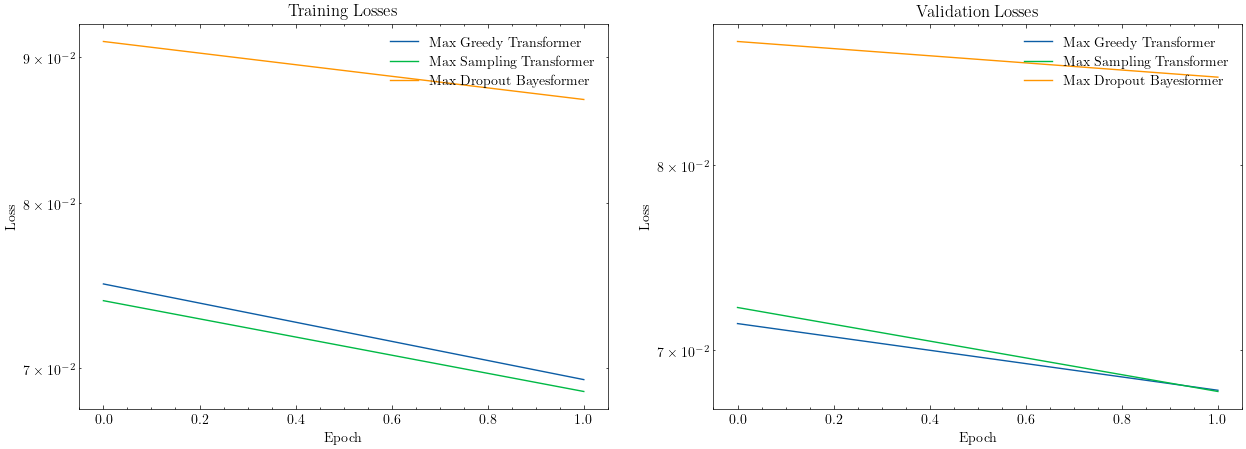

In [22]:
### PLOT : COMPARE LOSSES

visualization.plot_comparison_losses(
    [
        max_greedy_train_losses_transformer,
        max_sampling_train_losses_transformer,
        max_dropout_train_losses_bayesformer,
    ],
    [
        max_greedy_valid_losses_transformer,
        max_sampling_valid_losses_transformer,
        max_dropout_valid_losses_bayesformer,
    ],
    ["Max Greedy Transformer", "Max Sampling Transformer", "Max Dropout Bayesformer"],
    ylog=True,
)


### Active learning with margin uncertainty

In [23]:
margin_greedy_transformer = copy.deepcopy(transformer)
margin_sampling_transformer = copy.deepcopy(transformer)
margin_dropout_bayesformer = copy.deepcopy(bayesformer)


In [24]:
### ACTIVE LEARNING WITH MARGIN UNCERTAINTY : GREEDY TRANSFORMER

ids_margin_greedy_transformer = active_learning.select_samples(
    model=margin_greedy_transformer,
    tokenizer=tokenizer,
    pool_dataset=pool_dataset,
    device=DEVICE,
    nb_samples=200,
    compute="greedy",
    mode="margin",
)
margin_greedy_train_dataset = active_learning.create_new_train_set(
    train_dataset=train_dataset,
    pool_dataset=pool_dataset,
    indices=ids_margin_greedy_transformer,
)

margin_greedy_train_losses_transformer, margin_greedy_valid_losses_transformer = (
    utils.train(
        model=margin_greedy_transformer,
        train_dataset=margin_greedy_train_dataset,
        valid_dataset=valid_dataset,
        nb_epochs=AL_NB_EPOCHS,
        batch_size=AL_BATCH_SIZE,
        lr=AL_LEARNING_RATE,
        vocab_size=VOCAB_SIZE,
        tokenizer=tokenizer,
        device=DEVICE,
    )
)


EPOCH [1 / 2] ----------- TRAIN LOSS : 0.0744, VALID LOSS : 0.070545
EPOCH [2 / 2] ----------- TRAIN LOSS : 0.0697, VALID LOSS : 0.068190
Best valid loss : 0.0682


In [25]:
### ACTIVE LEARNING WITH MARGIN UNCERTAINTY : SAMPLING TRANSFORMER

ids_margin_sampling_transformer = active_learning.select_samples(
    model=margin_sampling_transformer,
    tokenizer=tokenizer,
    pool_dataset=pool_dataset,
    device=DEVICE,
    nb_samples=200,
    compute="sampling",
    mode="margin",
)
margin_sampling_train_dataset = active_learning.create_new_train_set(
    train_dataset=train_dataset,
    pool_dataset=pool_dataset,
    indices=ids_margin_sampling_transformer,
)

margin_sampling_train_losses_transformer, margin_sampling_valid_losses_transformer = (
    utils.train(
        model=margin_sampling_transformer,
        train_dataset=margin_sampling_train_dataset,
        valid_dataset=valid_dataset,
        nb_epochs=AL_NB_EPOCHS,
        batch_size=AL_BATCH_SIZE,
        lr=AL_LEARNING_RATE,
        vocab_size=VOCAB_SIZE,
        tokenizer=tokenizer,
        device=DEVICE,
    )
)


EPOCH [1 / 2] ----------- TRAIN LOSS : 0.0740, VALID LOSS : 0.072533
EPOCH [2 / 2] ----------- TRAIN LOSS : 0.0689, VALID LOSS : 0.069365
Best valid loss : 0.0694


In [26]:
### ACTIVE LEARNING WITH MARGIN UNCERTAINTY : DROPOUT BAYESFORMER

ids_margin_dropout_bayesformer = active_learning.select_samples(
    model=margin_dropout_bayesformer,
    tokenizer=tokenizer,
    pool_dataset=pool_dataset,
    device=DEVICE,
    nb_samples=200,
    compute="dropout",
    mode="margin",
)
margin_dropout_train_dataset = active_learning.create_new_train_set(
    train_dataset=train_dataset,
    pool_dataset=pool_dataset,
    indices=ids_margin_dropout_bayesformer,
)

margin_dropout_train_losses_bayesformer, margin_dropout_valid_losses_bayesformer = (
    utils.train(
        model=margin_dropout_bayesformer,
        train_dataset=margin_dropout_train_dataset,
        valid_dataset=valid_dataset,
        nb_epochs=AL_NB_EPOCHS,
        batch_size=AL_BATCH_SIZE,
        lr=AL_LEARNING_RATE,
        vocab_size=VOCAB_SIZE,
        tokenizer=tokenizer,
        device=DEVICE,
    )
)


EPOCH [1 / 2] ----------- TRAIN LOSS : 0.0914, VALID LOSS : 0.086896
EPOCH [2 / 2] ----------- TRAIN LOSS : 0.0868, VALID LOSS : 0.084227
Best valid loss : 0.0842


In [27]:
### ACCURACIES ON TEST SET

accuracy_test_margin_greedy_transformer = utils.evaluate(
    model=margin_greedy_transformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
accuracy_test_margin_sampling_transformer = utils.evaluate(
    model=margin_sampling_transformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
accuracy_test_margin_dropout_bayesformer = utils.evaluate(
    model=margin_dropout_bayesformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
print(
    f"Margin Greedy Transformer accuracy on test set: {accuracy_test_margin_greedy_transformer:.2f}"
)
print(
    f"Margin Sampling Transformer accuracy on test set: {accuracy_test_margin_sampling_transformer:.2f}"
)
print(
    f"Margin Dropout Bayesformer accuracy on test set: {accuracy_test_margin_dropout_bayesformer:.2f}"
)


Margin Greedy Transformer accuracy on test set: 0.01
Margin Sampling Transformer accuracy on test set: 0.00
Margin Dropout Bayesformer accuracy on test set: 0.00


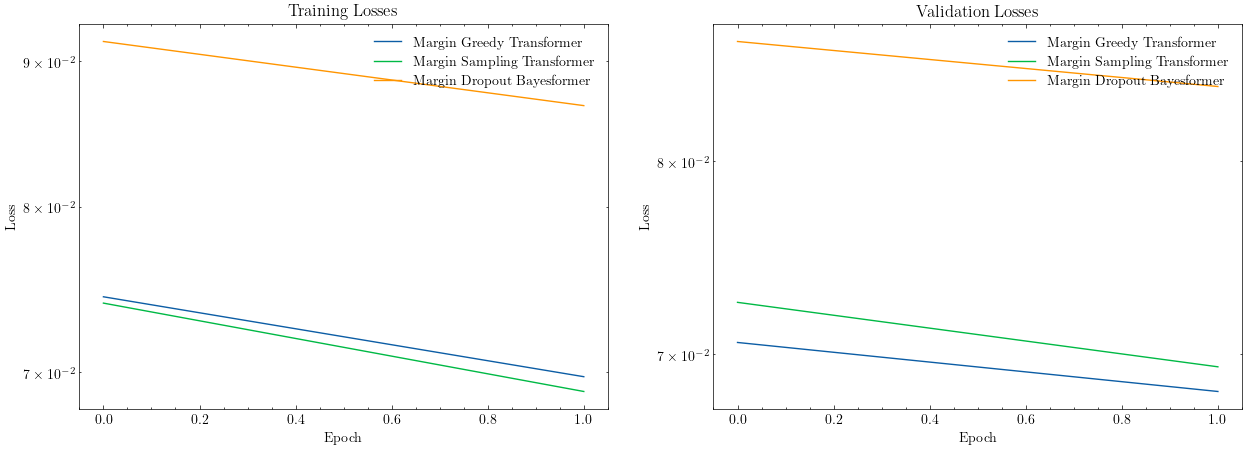

In [28]:
### PLOT : COMPARE LOSSES

visualization.plot_comparison_losses(
    [
        margin_greedy_train_losses_transformer,
        margin_sampling_train_losses_transformer,
        margin_dropout_train_losses_bayesformer,
    ],
    [
        margin_greedy_valid_losses_transformer,
        margin_sampling_valid_losses_transformer,
        margin_dropout_valid_losses_bayesformer,
    ],
    [
        "Margin Greedy Transformer",
        "Margin Sampling Transformer",
        "Margin Dropout Bayesformer",
    ],
    ylog=True,
)


### Active learning with entropy uncertainty

In [29]:
entropy_greedy_transformer = copy.deepcopy(transformer)
entropy_sampling_transformer = copy.deepcopy(transformer)
entropy_dropout_bayesformer = copy.deepcopy(bayesformer)


In [30]:
### ACTIVE LEARNING WITH ENTROPY UNCERTAINTY : GREEDY TRANSFORMER

ids_entropy_greedy_transformer = active_learning.select_samples(
    model=entropy_greedy_transformer,
    tokenizer=tokenizer,
    pool_dataset=pool_dataset,
    device=DEVICE,
    nb_samples=200,
    compute="greedy",
    mode="entropy",
)
entropy_greedy_train_dataset = active_learning.create_new_train_set(
    train_dataset=train_dataset,
    pool_dataset=pool_dataset,
    indices=ids_entropy_greedy_transformer,
)

entropy_greedy_train_losses_transformer, entropy_greedy_valid_losses_transformer = (
    utils.train(
        model=entropy_greedy_transformer,
        train_dataset=entropy_greedy_train_dataset,
        valid_dataset=valid_dataset,
        nb_epochs=AL_NB_EPOCHS,
        batch_size=AL_BATCH_SIZE,
        lr=AL_LEARNING_RATE,
        vocab_size=VOCAB_SIZE,
        tokenizer=tokenizer,
        device=DEVICE,
    )
)


EPOCH [1 / 2] ----------- TRAIN LOSS : 0.0744, VALID LOSS : 0.071074
EPOCH [2 / 2] ----------- TRAIN LOSS : 0.0694, VALID LOSS : 0.068567
Best valid loss : 0.0686


In [31]:
### ACTIVE LEARNING WITH ENTROPY UNCERTAINTY : SAMPLING TRANSFORMER

ids_entropy_sampling_transformer = active_learning.select_samples(
    model=entropy_sampling_transformer,
    tokenizer=tokenizer,
    pool_dataset=pool_dataset,
    device=DEVICE,
    nb_samples=200,
    compute="sampling",
    mode="entropy",
)
entropy_sampling_train_dataset = active_learning.create_new_train_set(
    train_dataset=train_dataset,
    pool_dataset=pool_dataset,
    indices=ids_entropy_sampling_transformer,
)

entropy_sampling_train_losses_transformer, entropy_sampling_valid_losses_transformer = (
    utils.train(
        model=entropy_sampling_transformer,
        train_dataset=entropy_sampling_train_dataset,
        valid_dataset=valid_dataset,
        nb_epochs=AL_NB_EPOCHS,
        batch_size=AL_BATCH_SIZE,
        lr=AL_LEARNING_RATE,
        vocab_size=VOCAB_SIZE,
        tokenizer=tokenizer,
        device=DEVICE,
    )
)


EPOCH [1 / 2] ----------- TRAIN LOSS : 0.0747, VALID LOSS : 0.071477
EPOCH [2 / 2] ----------- TRAIN LOSS : 0.0699, VALID LOSS : 0.068399
Best valid loss : 0.0684


In [32]:
### ACTIVE LEARNING WITH ENTROPY UNCERTAINTY : DROPOUT BAYESFORMER

ids_entropy_dropout_bayesformer = active_learning.select_samples(
    model=entropy_dropout_bayesformer,
    tokenizer=tokenizer,
    pool_dataset=pool_dataset,
    device=DEVICE,
    nb_samples=200,
    compute="dropout",
    mode="entropy",
)
entropy_dropout_train_dataset = active_learning.create_new_train_set(
    train_dataset=train_dataset,
    pool_dataset=pool_dataset,
    indices=ids_entropy_dropout_bayesformer,
)

entropy_dropout_train_losses_bayesformer, entropy_dropout_valid_losses_bayesformer = (
    utils.train(
        model=entropy_dropout_bayesformer,
        train_dataset=entropy_dropout_train_dataset,
        valid_dataset=valid_dataset,
        nb_epochs=AL_NB_EPOCHS,
        batch_size=AL_BATCH_SIZE,
        lr=AL_LEARNING_RATE,
        vocab_size=VOCAB_SIZE,
        tokenizer=tokenizer,
        device=DEVICE,
    )
)


EPOCH [1 / 2] ----------- TRAIN LOSS : 0.0920, VALID LOSS : 0.086461
EPOCH [2 / 2] ----------- TRAIN LOSS : 0.0864, VALID LOSS : 0.083119
Best valid loss : 0.0831


In [33]:
### ACCURACIES ON TEST SET

accuracy_test_entropy_greedy_transformer = utils.evaluate(
    model=entropy_greedy_transformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
accuracy_test_entropy_sampling_transformer = utils.evaluate(
    model=entropy_sampling_transformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
accuracy_test_entropy_dropout_bayesformer = utils.evaluate(
    model=entropy_dropout_bayesformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
print(
    f"Entropy Greedy Transformer accuracy on test set: {accuracy_test_entropy_greedy_transformer:.2f}"
)
print(
    f"Entropy Sampling Transformer accuracy on test set: {accuracy_test_entropy_sampling_transformer:.2f}"
)
print(
    f"Entropy Dropout Bayesformer accuracy on test set: {accuracy_test_entropy_dropout_bayesformer:.2f}"
)


Entropy Greedy Transformer accuracy on test set: 0.00
Entropy Sampling Transformer accuracy on test set: 0.01
Entropy Dropout Bayesformer accuracy on test set: 0.00


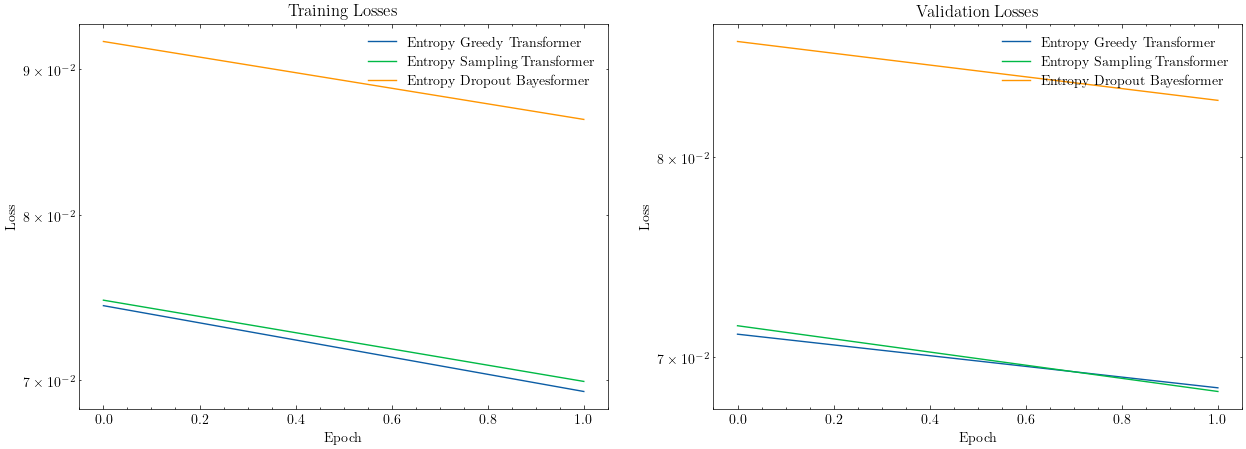

In [34]:
### PLOT : COMPARE LOSSES

visualization.plot_comparison_losses(
    [
        entropy_greedy_train_losses_transformer,
        entropy_sampling_train_losses_transformer,
        entropy_dropout_train_losses_bayesformer,
    ],
    [
        entropy_greedy_valid_losses_transformer,
        entropy_sampling_valid_losses_transformer,
        entropy_dropout_valid_losses_bayesformer,
    ],
    [
        "Entropy Greedy Transformer",
        "Entropy Sampling Transformer",
        "Entropy Dropout Bayesformer",
    ],
    ylog=True,
)


### Active learning : uncertainty method comparison for each model

**GREEDY TRANSFORMER**

In [35]:
### ACCURACIES ON TEST SET

print(
    f"Max Greedy Transformer accuracy on test set: {accuracy_test_max_greedy_transformer:.2f}"
)
print(
    f"Margin Greedy Transformer accuracy on test set: {accuracy_test_margin_greedy_transformer:.2f}"
)
print(
    f"Entropy Greedy Transformer accuracy on test set: {accuracy_test_entropy_greedy_transformer:.2f}"
)


Max Greedy Transformer accuracy on test set: 0.01
Margin Greedy Transformer accuracy on test set: 0.01
Entropy Greedy Transformer accuracy on test set: 0.00


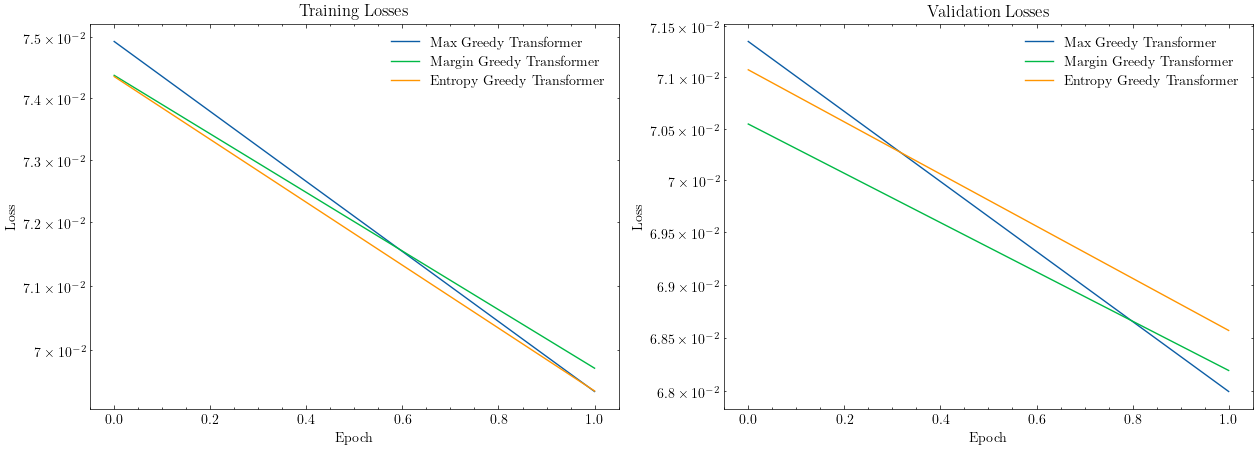

In [36]:
### PLOT : COMPARE LOSSES

visualization.plot_comparison_losses(
    [
        max_greedy_train_losses_transformer,
        margin_greedy_train_losses_transformer,
        entropy_greedy_train_losses_transformer,
    ],
    [
        max_greedy_valid_losses_transformer,
        margin_greedy_valid_losses_transformer,
        entropy_greedy_valid_losses_transformer,
    ],
    [
        "Max Greedy Transformer",
        "Margin Greedy Transformer",
        "Entropy Greedy Transformer",
    ],
    ylog=True,
)


**SAMPLING TRANSFORMER**

In [37]:
### ACCURACIES ON TEST SET

print(
    f"Max Sampling Transformer accuracy on test set: {accuracy_test_max_sampling_transformer:.2f}"
)
print(
    f"Margin Sampling Transformer accuracy on test set: {accuracy_test_margin_sampling_transformer:.2f}"
)
print(
    f"Entropy Sampling Transformer accuracy on test set: {accuracy_test_entropy_sampling_transformer:.2f}"
)


Max Sampling Transformer accuracy on test set: 0.01
Margin Sampling Transformer accuracy on test set: 0.00
Entropy Sampling Transformer accuracy on test set: 0.01


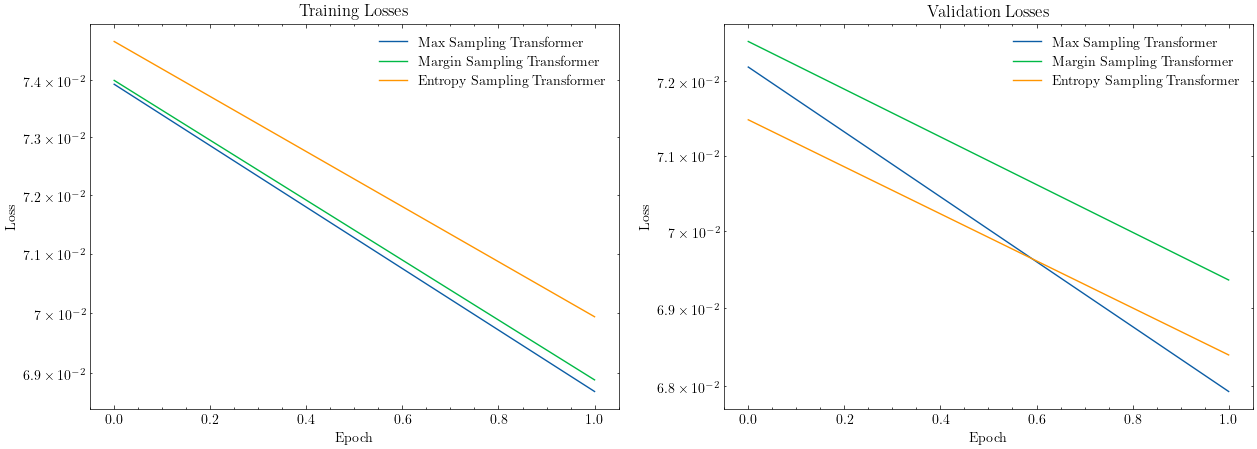

In [38]:
### PLOT : COMPARE LOSSES

visualization.plot_comparison_losses(
    [
        max_sampling_train_losses_transformer,
        margin_sampling_train_losses_transformer,
        entropy_sampling_train_losses_transformer,
    ],
    [
        max_sampling_valid_losses_transformer,
        margin_sampling_valid_losses_transformer,
        entropy_sampling_valid_losses_transformer,
    ],
    [
        "Max Sampling Transformer",
        "Margin Sampling Transformer",
        "Entropy Sampling Transformer",
    ],
    ylog=True,
)


**DROPOUT BAYESFORMER**

In [39]:
### ACCURACIES ON TEST SET

print(
    f"Max Dropout Bayesformer accuracy on test set: {accuracy_test_max_dropout_bayesformer:.2f}"
)
print(
    f"Margin Dropout Bayesformer accuracy on test set: {accuracy_test_margin_dropout_bayesformer:.2f}"
)
print(
    f"Entropy Dropout Bayesformer accuracy on test set: {accuracy_test_entropy_dropout_bayesformer:.2f}"
)


Max Dropout Bayesformer accuracy on test set: 0.00
Margin Dropout Bayesformer accuracy on test set: 0.00
Entropy Dropout Bayesformer accuracy on test set: 0.00


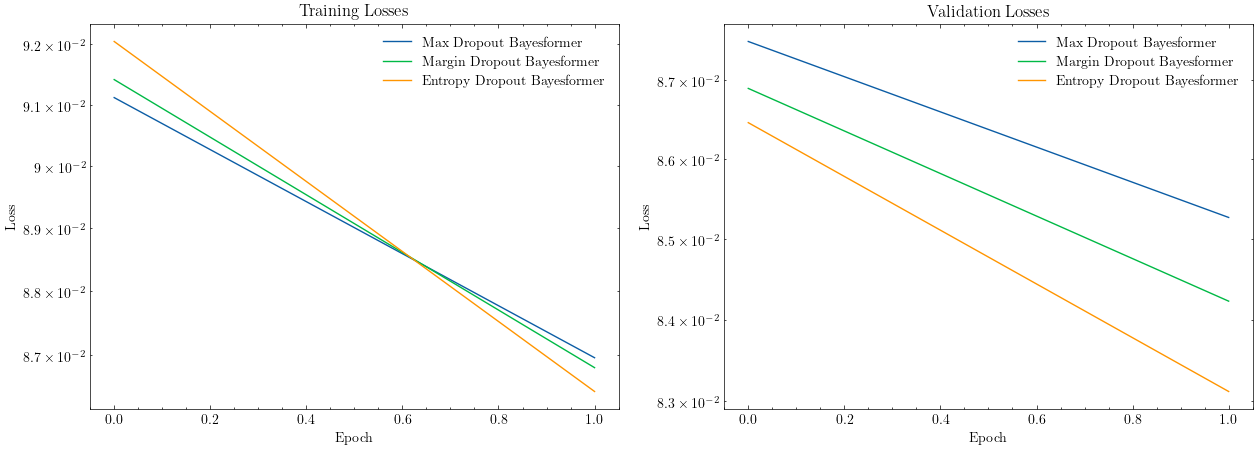

In [40]:
### PLOT : COMPARE LOSSES

visualization.plot_comparison_losses(
    [
        max_dropout_train_losses_bayesformer,
        margin_dropout_train_losses_bayesformer,
        entropy_dropout_train_losses_bayesformer,
    ],
    [
        max_dropout_valid_losses_bayesformer,
        margin_dropout_valid_losses_bayesformer,
        entropy_dropout_valid_losses_bayesformer,
    ],
    [
        "Max Dropout Bayesformer",
        "Margin Dropout Bayesformer",
        "Entropy Dropout Bayesformer",
    ],
    ylog=True,
)
